In [42]:
%pip install torchinfo

In [43]:
import torch
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import numpy as np
import torch.nn as nn
from torchinfo import summary

In [44]:
path = './MURA-v1.1/'
train_image_paths_csv = "train_image_paths.csv"
df_train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
df_train_images_paths.columns = ['image_path']

In [45]:
df_train_images_paths['label'] = df_train_images_paths['image_path'].map(lambda x: 'positive' if 'positive' in x else 'negative')
df_train_images_paths['category'] = df_train_images_paths['image_path'].apply(lambda x: x.split('/')[2])
#df_train_images_paths['patientId'] = df_train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

In [46]:
valid_image_paths_csv = "valid_image_paths.csv"
df_valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
df_valid_data_paths.columns = ['image_path']

In [47]:
df_valid_data_paths['label'] = df_valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
df_valid_data_paths['category']  = df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])
#df_valid_data_paths['dir'] =  df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
#df_valid_data_paths['patientId']  = df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

In [48]:
df_train_images_paths["label"] = df_train_images_paths["label"].replace({'positive': 1, 'negative': 0})


In [49]:
df_valid_data_paths["label"] = df_valid_data_paths["label"].replace({'positive': 1, 'negative': 0})


In [50]:
# Sampling 
negative_class = df_train_images_paths[ df_train_images_paths['label'] == 0]
postive_class = df_train_images_paths[ df_train_images_paths['label'] == 1]
equal_train_split_negative = negative_class.sample(n=len(postive_class), random_state=62)

# googlenet

In [51]:
train_label_counts = df_train_images_paths["label"].value_counts()
valid_label_counts = df_valid_data_paths["label"].value_counts()

print("Training Labels Counts:\n", train_label_counts)
print("\nValidation Labels Counts:\n", valid_label_counts)


Training Labels Counts:
 label
0    21935
1    14873
Name: count, dtype: int64

Validation Labels Counts:
 label
0    1667
1    1530
Name: count, dtype: int64


# Downsampling

In [52]:
# Create an empty list to store the downsampled dataframes
dfs = []

# Loop through each unique category
for category in df_train_images_paths['category'].unique():
    
    # Filter the data for the current category
    category_data = df_train_images_paths[df_train_images_paths['category'] == category]
    
    # Get the counts of label 0 and label 1 for the current category
    negative_count = len(category_data[category_data['label'] == 0])
    positive_count = len(category_data[category_data['label'] == 1])
    
    # Determine the minimum of the two counts
    min_count = min(negative_count, positive_count)
    
    # Downsample both label groups to the minimum count
    downsampled_negative = category_data[category_data['label'] == 0].sample(n=min_count, random_state=62)
    downsampled_positive = category_data[category_data['label'] == 1].sample(n=min_count, random_state=62)
    
    # Concatenate the downsampled negative and positive groups
    balanced_category_data = pd.concat([downsampled_negative, downsampled_positive])
    
    # Append the balanced dataframe to the list
    dfs.append(balanced_category_data)

# Combine all the balanced dataframes
balanced_df = pd.concat(dfs)

# Print out the new distribution
print(balanced_df.groupby(['category', 'label']).size())


category     label
XR_ELBOW     0        2006
             1        2006
XR_FINGER    0        1968
             1        1968
XR_FOREARM   0         661
             1         661
XR_HAND      0        1484
             1        1484
XR_HUMERUS   0         599
             1         599
XR_SHOULDER  0        4168
             1        4168
XR_WRIST     0        3987
             1        3987
dtype: int64


In [53]:
balanced_df.count()

image_path    29746
label         29746
category      29746
dtype: int64

In [54]:
df_train_images_paths.head()

,image_path,label,category
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,XR_SHOULDER
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,XR_SHOULDER
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,XR_SHOULDER
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,XR_SHOULDER
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,XR_SHOULDER


In [55]:
balanced_df.head()

,image_path,label,category
8326,MURA-v1.1/train/XR_SHOULDER/patient02676/study...,0,XR_SHOULDER
6040,MURA-v1.1/train/XR_SHOULDER/patient01949/study...,0,XR_SHOULDER
6283,MURA-v1.1/train/XR_SHOULDER/patient02024/study...,0,XR_SHOULDER
7567,MURA-v1.1/train/XR_SHOULDER/patient02434/study...,0,XR_SHOULDER
6698,MURA-v1.1/train/XR_SHOULDER/patient02163/study...,0,XR_SHOULDER


In [56]:
label_distribution_per_category = df_train_images_paths.groupby('category')['label'].value_counts()
for (category, label), count in label_distribution_per_category.items():
    print(f"Category: {category}, Label: {label}, Count: {count}")


Category: XR_ELBOW, Label: 0, Count: 2925
Category: XR_ELBOW, Label: 1, Count: 2006
Category: XR_FINGER, Label: 0, Count: 3138
Category: XR_FINGER, Label: 1, Count: 1968
Category: XR_FOREARM, Label: 0, Count: 1164
Category: XR_FOREARM, Label: 1, Count: 661
Category: XR_HAND, Label: 0, Count: 4059
Category: XR_HAND, Label: 1, Count: 1484
Category: XR_HUMERUS, Label: 0, Count: 673
Category: XR_HUMERUS, Label: 1, Count: 599
Category: XR_SHOULDER, Label: 0, Count: 4211
Category: XR_SHOULDER, Label: 1, Count: 4168
Category: XR_WRIST, Label: 0, Count: 5765
Category: XR_WRIST, Label: 1, Count: 3987


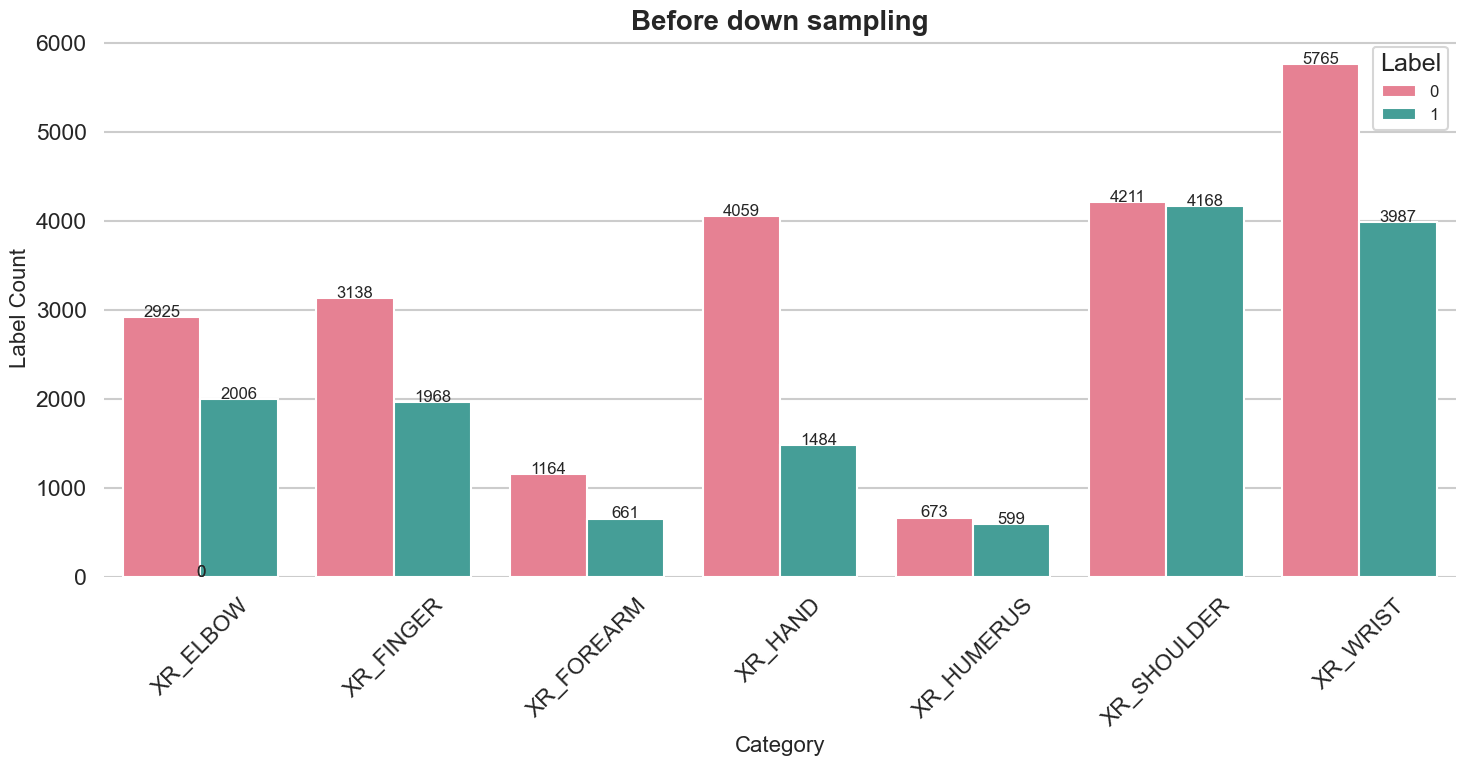

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")
sns.set_context("talk")  # makes elements larger (e.g., for presentations)

# Get the label distribution per category
label_distribution_per_category = df_train_images_paths.groupby('category')['label'].value_counts().reset_index(name='count')

# Define a custom color palette
palette = sns.color_palette("husl", n_colors=label_distribution_per_category['label'].nunique())

# Plot
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=label_distribution_per_category, x='category', y='count', hue='label', palette=palette)
plt.title('Before down sampling', fontsize=20, fontweight='bold')
plt.ylabel('Label Count', fontsize=16)
plt.xlabel('Category', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Label', fontsize=12)

# Annotate bars with their values
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:1.0f}'.format(height),
            ha="center", fontsize=12)

sns.despine(left=True, bottom=True)  # remove left and bottom spines
plt.tight_layout()
plt.show()


In [58]:
train_label_counts = balanced_df["label"].value_counts()
valid_label_counts = df_valid_data_paths["label"].value_counts()

print("Training Labels Counts:\n", train_label_counts)
print("\nValidation Labels Counts:\n", valid_label_counts)


Training Labels Counts:
 label
0    14873
1    14873
Name: count, dtype: int64

Validation Labels Counts:
 label
0    1667
1    1530
Name: count, dtype: int64


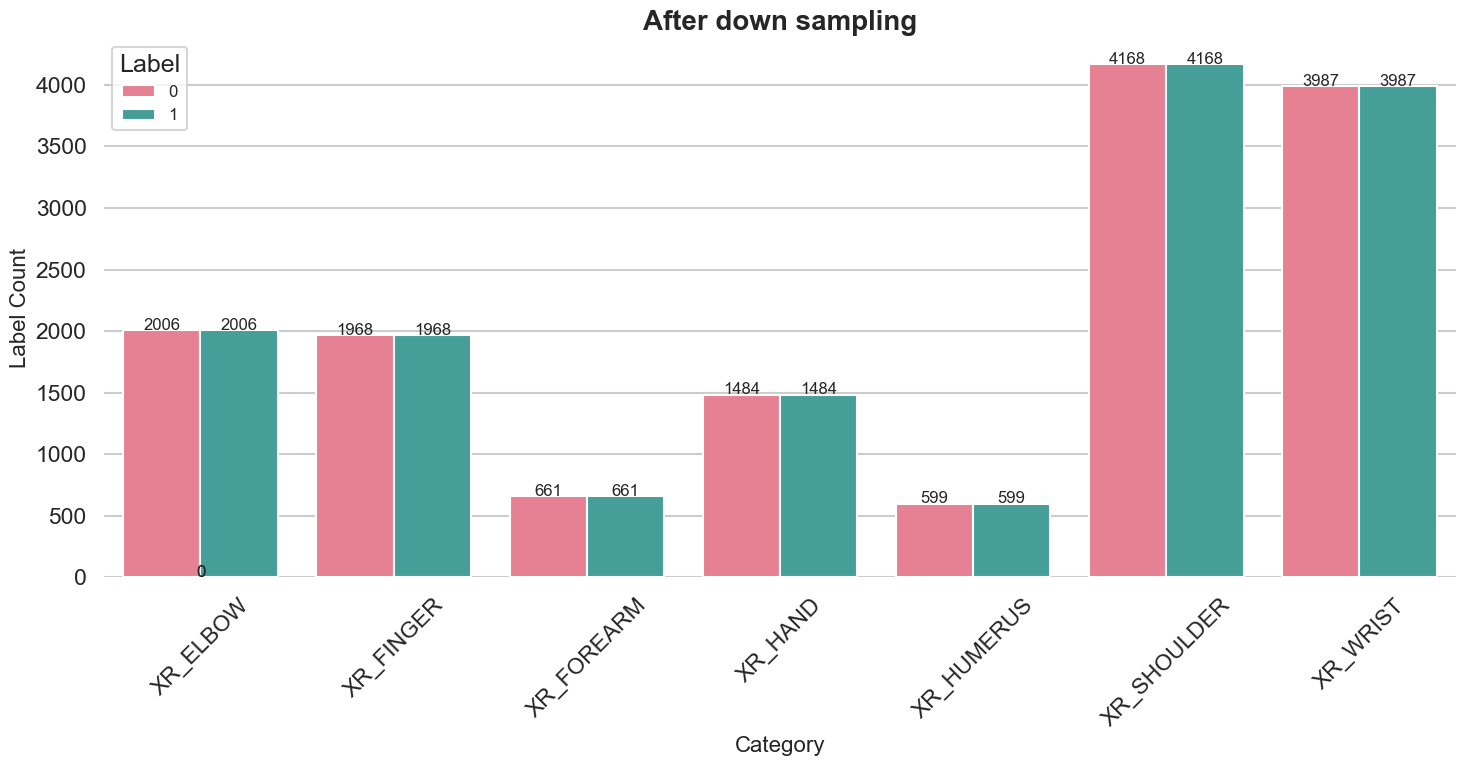

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")
sns.set_context("talk")  # makes elements larger (e.g., for presentations)

# Get the label distribution per category
label_distribution_per_category = balanced_df.groupby('category')['label'].value_counts().reset_index(name='count')

# Define a custom color palette
palette = sns.color_palette("husl", n_colors=label_distribution_per_category['label'].nunique())

# Plot
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=label_distribution_per_category, x='category', y='count', hue='label', palette=palette)
plt.title('After down sampling', fontsize=20, fontweight='bold')
plt.ylabel('Label Count', fontsize=16)
plt.xlabel('Category', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Label', fontsize=12)

# Annotate bars with their values
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:1.0f}'.format(height),
            ha="center", fontsize=12)

sns.despine(left=True, bottom=True)  # remove left and bottom spines
plt.tight_layout()
plt.show()


In [60]:
import torchvision.models as models

googlenet = models.googlenet(pretrained=False,aux_logits=False)

c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


# DataLoader

In [61]:
from skimage.filters import butterworth
from skimage.filters import gaussian
from skimage import exposure



In [62]:
from torch.utils.data import Dataset
from skimage import img_as_ubyte
from skimage.color import rgb2gray
class MuraDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, device='cpu'):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        
        # Convert PIL Image to numpy array
        image_np = np.array(image)
        
        image_gray = rgb2gray(image_np)
        
        # Apply adaptive histogram equalization
        image_gray = exposure.equalize_adapthist(image_gray, clip_limit=0.02)

        
        # Apply Butterworth filter
        image_butterworth = butterworth(image_gray)

        
        # Apply Gaussian filter
        image_gaussian = gaussian(image_gray)
        
        # Combine the two images into one (stack them along the last axis)
        # Create a 3 channel image from the butterworth and gaussian filtered images
        image_combined = np.stack([image_butterworth, image_gaussian, image_gray], axis=-1)
        
        image_combined = (image_combined - np.min(image_combined)) / (np.max(image_combined) - np.min(image_combined))
        
        # Convert to 8-bit image for PIL
        image_combined = img_as_ubyte(image_combined)
        
        # Convert numpy array back to PIL Image
        image = Image.fromarray(image_combined)
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        image = image.to(self.device)
        
        label = torch.tensor(label).to(self.device)

        return image, label


In [63]:
balanced_df=balanced_df.reset_index(drop=True)

In [64]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2

mean_values = [0.2665, 0.4648, 0.4648]# Calculated
std_values = [0.1079, 0.1650, 0.1666] # Calculated
batchsize = 32
transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),  # Already included
    v2.RandomVerticalFlip(p=0.5),  # New: vertical flip
    v2.RandomRotation(10),  # New: random rotation with a maximum rotation angle of 10 degrees
    v2.Resize((224, 224)),  # Already included
    v2.ToTensor(),  # Already included
    v2.Normalize(mean=mean_values, std=std_values)  # Normalization step

])

val_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=mean_values, std=std_values),
])

Mura_transform = MuraDataset(balanced_df["image_path"], balanced_df["label"], transform=transform,device='cuda')
train_loader = DataLoader(Mura_transform, batch_size=batchsize, shuffle=True)
Mura_transform_valid = MuraDataset(df_valid_data_paths["image_path"], df_valid_data_paths["label"], transform=val_transform,device='cuda')
valid_loader = DataLoader(Mura_transform_valid, batch_size=batchsize)



c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [65]:
Mura_transform_valid = MuraDataset(df_valid_data_paths["image_path"], df_valid_data_paths["label"], transform=val_transform,device='cuda')
valid_loader = DataLoader(Mura_transform_valid, batch_size=batchsize)

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


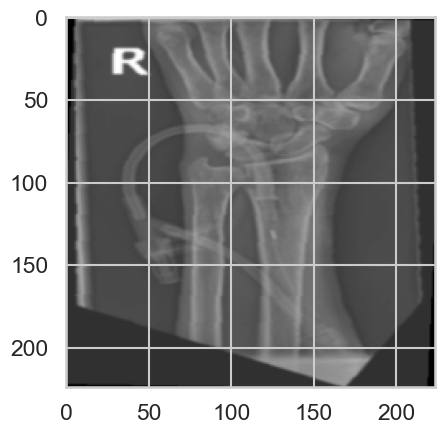

Label: 0


In [66]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Select a single image from the batch.
img = train_features[0]

# Select one channel (e.g., the first channel).
img_channel1 = img[1].cpu().numpy()

# Display the selected channel.
plt.imshow(img_channel1, cmap="gray")
plt.show()

# Alternatively, you can display the second channel
# img_channel2 = img[1].cpu().numpy()
# plt.imshow(img_channel2, cmap="gray")
# plt.show()

label = train_labels[0]
print(f"Label: {label}")


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [68]:
summary(googlenet, input_size=(32, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [32, 1000]                --
├─BasicConv2d: 1-1                       [32, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                  [32, 64, 112, 112]        128
├─MaxPool2d: 1-2                         [32, 64, 56, 56]          --
├─BasicConv2d: 1-3                       [32, 64, 56, 56]          --
│    └─Conv2d: 2-3                       [32, 64, 56, 56]          4,096
│    └─BatchNorm2d: 2-4                  [32, 64, 56, 56]          128
├─BasicConv2d: 1-4                       [32, 192, 56, 56]         --
│    └─Conv2d: 2-5                       [32, 192, 56, 56]         110,592
│    └─BatchNorm2d: 2-6                  [32, 192, 56, 56]         384
├─MaxPool2d: 1-5                         [32, 192, 28, 28]         --
├─Inception: 1-6                         [32, 256, 28, 28]         --
│

In [69]:
num_ftrs = googlenet.fc.in_features 
googlenet.fc = torch.nn.Linear(num_ftrs, 2)  

In [70]:
summary(googlenet, input_size=(32, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [32, 2]                   --
├─BasicConv2d: 1-1                       [32, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                  [32, 64, 112, 112]        128
├─MaxPool2d: 1-2                         [32, 64, 56, 56]          --
├─BasicConv2d: 1-3                       [32, 64, 56, 56]          --
│    └─Conv2d: 2-3                       [32, 64, 56, 56]          4,096
│    └─BatchNorm2d: 2-4                  [32, 64, 56, 56]          128
├─BasicConv2d: 1-4                       [32, 192, 56, 56]         --
│    └─Conv2d: 2-5                       [32, 192, 56, 56]         110,592
│    └─BatchNorm2d: 2-6                  [32, 192, 56, 56]         384
├─MaxPool2d: 1-5                         [32, 192, 28, 28]         --
├─Inception: 1-6                         [32, 256, 28, 28]         --
│

In [71]:
googlenet.to(device=device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# New Optimizer

## According to the paper it's suggested for the lion optimizer to be 3-10x smaller than the AdamW opt if AdamW opt Lr is 1e-5 so the new Lr should be 3.33e-6
## We divided 1e-5 by 3 and multiply the weight decay by 3

In [72]:
googlenetModel= torch.load('Models weights\googlenet_mura_phase_3_20epoch.pth')

In [73]:
from lion_pytorch import Lion
optimizer = Lion(googlenetModel.parameters(), lr=3.33e-5, weight_decay=1e-2)

In [74]:
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(googlenet.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

In [75]:
num_epochs = 10

for epoch in range(num_epochs):
    googlenetModel.train()
    total_loss = 0.0
    correct = 0  # To keep track of correct predictions
    total = 0  # To keep track of total predictions

    batch_accuracies = []  # To store batch accuracies for the epoch

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenetModel(images)

        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        
        _, predicted = outputs.max(1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print loss and accuracy for every 100 batches
        if (batch_idx + 1) % 100 == 0:
            batch_accuracy = 100. * correct / total
            batch_accuracies.append(batch_accuracy)  # Store the batch accuracy
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Batch Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy:.2f}%")
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total  # Convert to percentage

    # Calculate the average of batch accuracies for the epoch
    avg_batch_accuracy = sum(batch_accuracies) / len(batch_accuracies) if batch_accuracies else 0.0

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Epoch Accuracy: {epoch_accuracy:.2f}%, Average Batch Accuracy: {avg_batch_accuracy:.2f}%")


Epoch [1/10], Batch [100/930], Batch Loss: 0.6673, Batch Accuracy: 62.56%


KeyboardInterrupt: 

# learning rate after 40 epoch and step decay 1.9197e−6

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Switch the model to evaluation mode
googlenetModel.eval()

# Initialize lists to store all true labels and all predictions
all_labels = []
all_predictions = []    

# Disabling gradient calculation
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(valid_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = googlenetModel(images)  
        

        # Get predictions
        _, predicted = outputs.max(1)

        # Store predictions and true labels for later calculation of metrics
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Print status for every 50 batches (or another number if you prefer)
        if (batch_idx + 1) % 100 == 0:
            print(f"Test Batch [{batch_idx+1}/{len(valid_loader)}] Processed")


# Compute metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)  # Using weighted average if you have class imbalance
recall = recall_score(all_labels, all_predictions)  # Using weighted average if you have class imbalance
f1 = f1_score(all_labels, all_predictions)  # Using weighted average if you have class imbalance

    
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")



Test Batch [100/100] Processed
Test Accuracy: 0.5455
Test Precision: 0.6005
Test Recall: 0.1503
Test F1-Score: 0.2405


# Test Accuracy: 0.7760

# Test Precision: 0.7791

# Test Recall: 0.7425

# Test F1-Score: 0.7604

In [ ]:
import torch
save_path = 'googlenet_mura_Norma_PART3LionOPT_35epoch.pth'
torch.save(googlenet,save_path)